Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
#library versions
!pip install -U scikit-learn
!python -m pip show scikit-learn


Requirement already up-to-date: scikit-learn in /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages (0.23.1)
Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages
Requires: numpy, scipy, threadpoolctl, joblib
Required-by: sklearn, shap, PDPbox, eli5, category-encoders


In [2]:
#importing data
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/JonRivera/JonRivera.github.io/master/Unit2/Buil_Week/Data_Sets/Hotel_Bookings/hotel_bookings.csv")

/Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
def wrangle(df):
    df = df.copy()
    #drop unecessary columns, or columns that seem to have little impact on target
    df = df.drop(['company', 'agent','arrival_date_week_number'],axis = 1)
    df = df.dropna(axis=0)  
    #set date column to index
    #doesn't add any substantial info, and has high cardinality. 
    #arrivate_date year,month, day already include this info ..
    df.set_index(pd.to_datetime(df['reservation_status_date']), inplace = True)
    df = df.drop(['reservation_status_date'], axis=1)
    #I am treating cancelations as people who canceled or did not show
    #on there arrival date --- it was assumend the hotel would cancel there stay 
    
    df['reservation_status'] =  df['reservation_status'].replace({'No-Show':'Canceled'})
    return df
df = wrangle(df)


In [6]:
#get train, validate,and test subsets
train = df[df['arrival_date_year']==2015].copy()
val = df[df['arrival_date_year']==2016].copy()
test = df[df['arrival_date_year'] == 2017].copy()
train.shape, val.shape, test.shape

((21859, 28), (56435, 28), (40604, 28))

In [7]:
pd.set_option('max_columns', 40)
train.tail(500)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-11,City Hotel,0,25,2015,December,4,2,5,2,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,72.93,0,0,Check-Out
2015-12-11,City Hotel,0,1,2015,December,10,0,1,1,0.0,0,BB,ITA,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,85.00,0,0,Check-Out
2015-12-11,City Hotel,0,6,2015,December,10,0,1,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient-Party,0.00,0,0,Check-Out
2015-12-11,City Hotel,0,6,2015,December,10,0,1,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient-Party,0.00,0,0,Check-Out
2015-12-11,City Hotel,1,14,2015,December,11,2,5,1,0.0,0,BB,AGO,Direct,Direct,0,0,0,E,E,1,No Deposit,0,Transient,104.00,0,1,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-26,City Hotel,0,4,2015,August,23,2,1,1,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,1,No Deposit,0,Transient,0.00,0,1,Check-Out
2015-10-16,City Hotel,0,0,2015,October,15,0,1,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,1,D,D,0,No Deposit,0,Transient,0.00,0,0,Check-Out
2015-12-13,City Hotel,0,1,2015,December,12,0,1,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,2,A,A,1,No Deposit,0,Transient,0.00,0,0,Check-Out


In [8]:
train.describe(exclude='number')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859
unique,2,6,5,98,6,5,9,11,3,4,2
top,City Hotel,September,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,13663,5084,17106,13303,6148,17691,17614,14376,18202,11319,13753


In [9]:
train['deposit_type'].value_counts(normalize=True)

No Deposit    0.832700
Non Refund    0.167117
Refundable    0.000183
Name: deposit_type, dtype: float64

In [10]:
train[train['deposit_type']=='Non Refund']['reservation_status'].value_counts(normalize=True)

Canceled     0.997536
Check-Out    0.002464
Name: reservation_status, dtype: float64

In [11]:
train[train['deposit_type']=='No Deposit']['reservation_status'].value_counts(normalize=True)

Check-Out    0.754862
Canceled     0.245138
Name: reservation_status, dtype: float64

In [12]:
val['deposit_type'].value_counts(normalize=True)

No Deposit    0.877292
Non Refund    0.120386
Refundable    0.002321
Name: deposit_type, dtype: float64

In [13]:
val[val['deposit_type']=='Non Refund']['reservation_status'].value_counts(normalize=True)

Canceled     0.988814
Check-Out    0.011186
Name: reservation_status, dtype: float64

In [14]:
train[train['deposit_type']=='No Deposit']['reservation_status'].value_counts(normalize=True)

Check-Out    0.754862
Canceled     0.245138
Name: reservation_status, dtype: float64

In [15]:
#feature selection
# is_canceled is also a target vector, reveals reservation_status implicitly ... is leaking information of target
def features_select(df):    
    target = 'reservation_status'
    #creating subsets of features, splitted between numerical and categorical
    train_features =  df.drop(columns = [target, 'is_canceled'],axis =1)
    numeric_features = train_features.select_dtypes(include='number').columns.tolist()
    cardinality = train_features.select_dtypes(exclude = 'number').nunique()
    categorical_features = cardinality.index.tolist()
    #combine lists to extrapolate features of interest
    features = numeric_features + categorical_features
    return features
features = features_select(df)


#These columns to be the most important ones, so I will do some feature engineering to see if i can improve my score

In [16]:
#seperating X matrices and correspind y vectors
target = 'reservation_status'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val= val[features]
y_val = val[target]
X_train.shape,y_train.shape,X_val.shape, y_val.shape

((21859, 26), (21859,), (56435, 26), (56435,))

In [17]:
#baselines
y_train.value_counts(normalize=True)


Check-Out    0.629169
Canceled     0.370831
Name: reservation_status, dtype: float64

##Permuation Importance

In [18]:
y_val.value_counts(normalize=True)


Check-Out    0.640064
Canceled     0.359936
Name: reservation_status, dtype: float64

Build Model

In [19]:
#instantitate classes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [20]:
#Build pipeline using RadnomSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model0 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs = -1, random_state=40)

)

param_distributions = { 
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': [5,10,20],
    'randomforestclassifier__min_samples_split': [5,10,15,20],
    'randomforestclassifier__min_samples_leaf': [2]
}
search = RandomizedSearchCV(
    model0, 
    param_distributions = param_distributions,
    n_iter = 10,
    cv=10,
    scoring ='accuracy',
    verbose = 1,
    return_train_score = True,
    n_jobs = -1
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator:' ,search.best_params_)
print('Best Model', search.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Cross-validation Best Score 0.8356331638196888
Best Estimator: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 20, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'entropy'}
Best Model Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
             

In [21]:
model0 = search.best_estimator_
model0

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
                                         {'col': 'arrival_date_month',
                                          'data_type...
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64},
                                         {'col': 'customer_ty

In [22]:
model0.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
                                         {'col': 'arrival_date_month',
                                          'data_type...
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: int64},
                                         {'col': 'customer_ty

In [23]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

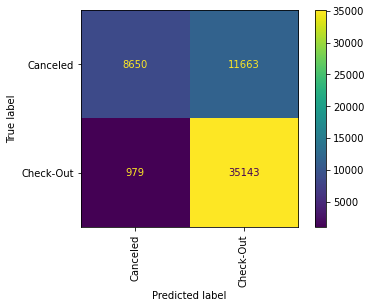

In [24]:
plot_confusion_matrix(model0, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [25]:
y_pred0 = model0.predict(X_val)

In [26]:
print(classification_report(y_val, y_pred0))

              precision    recall  f1-score   support

    Canceled       0.90      0.43      0.58     20313
   Check-Out       0.75      0.97      0.85     36122

    accuracy                           0.78     56435
   macro avg       0.82      0.70      0.71     56435
weighted avg       0.80      0.78      0.75     56435



Model Importances

In [27]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance


/Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Run XGBoost w/ Early Stopping to Prevent Overfitting and Optimize Estimators

In [28]:
from xgboost.sklearn import XGBClassifier
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model1 = XGBClassifier(
        n_estimators = 20, 
        max_depth = 5,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model1.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 20)

[0]	validation_0-auc:0.95199	validation_1-auc:0.75255
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.96177	validation_1-auc:0.75369
[2]	validation_0-auc:0.96799	validation_1-auc:0.75729
[3]	validation_0-auc:0.97038	validation_1-auc:0.74851
[4]	validation_0-auc:0.97221	validation_1-auc:0.76796
[5]	validation_0-auc:0.97388	validation_1-auc:0.75801
[6]	validation_0-auc:0.97455	validation_1-auc:0.77523
[7]	validation_0-auc:0.97626	validation_1-auc:0.78594
[8]	validation_0-auc:0.97696	validation_1-auc:0.78500
[9]	validation_0-auc:0.97789	validation_1-auc:0.79331
[10]	validation_0-auc:0.97876	validation_1-auc:0.79618
[11]	validation_0-auc:0.97980	validation_1-auc:0.79321
[12]	validation_0-auc:0.98119	validation_1-auc:0.79333
[13]	validation_0-auc:0.98153	validation_1-auc:0.78949
[14]	validation_0-auc:0.98296	validation_1-auc:0.79185
[15]	validation_0-auc:0.9837

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
model1.score(X_val_encoded,y_val)

0.7725170550190484

In [30]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    model1,
    scoring = 'accuracy',
    n_iter= 5,
    random_state = 42
    )
permuter.fit(X_val_encoded,y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=5,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=20, n_jobs=-1,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,
                                              r

In [31]:
permuter.feature_importances_
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

deposit_type                      0.119419
country                           0.027100
previous_cancellations            0.014278
lead_time                         0.011946
required_car_parking_spaces       0.003962
assigned_room_type                0.003519
reserved_room_type                0.003345
adr                               0.003044
previous_bookings_not_canceled    0.002218
stays_in_week_nights              0.001861
distribution_channel              0.001744
booking_changes                   0.001559
adults                            0.001081
total_of_special_requests         0.000663
customer_type                     0.000496
meal                              0.000450
is_repeated_guest                 0.000252
days_in_waiting_list              0.000145
children                          0.000135
babies                            0.000000
arrival_date_year                 0.000000
arrival_date_day_of_month        -0.000252
stays_in_weekend_nights          -0.000787
hotel      

In [32]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter,
    top=None, # shows permutation importances of all features
    feature_names = feature_names

)

Weight,Feature
0.1194 ± 0.0032,deposit_type
0.0271 ± 0.0010,country
0.0143 ± 0.0008,previous_cancellations
0.0119 ± 0.0012,lead_time
0.0040 ± 0.0008,required_car_parking_spaces
0.0035 ± 0.0006,assigned_room_type
0.0033 ± 0.0004,reserved_room_type
0.0030 ± 0.0007,adr
0.0022 ± 0.0001,previous_bookings_not_canceled
0.0019 ± 0.0003,stays_in_week_nights


In [33]:
permuter.feature_importances_

array([ 0.01194649,  0.        , -0.00025162, -0.00078675,  0.00186055,
        0.00108089,  0.00013467,  0.        ,  0.00025162,  0.01427837,
        0.00221848,  0.00155932,  0.0001453 ,  0.00304421,  0.00396208,
        0.00066271, -0.00082573, -0.0015664 ,  0.00045008,  0.0271002 ,
       -0.00197041,  0.0017436 ,  0.00334544,  0.00351909,  0.1194188 ,
        0.00049615])

In [34]:
y_pred1 = model1.predict(X_val_encoded)


In [35]:
#Feature Selection Based on Permuation Importances

In [36]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (21859, 26)


In [37]:
minimum_importance = 0.0001
permuter.feature_importances_ >minimum_importance

array([ True, False, False, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True])

In [38]:
mask = permuter.feature_importances_ > minimum_importance

In [39]:
#Using Features from Permutation Importances
features = list(X_train.columns[mask])
features

['lead_time',
 'stays_in_week_nights',
 'adults',
 'children',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [40]:
X_train1 = X_train[features]
print('Shape after removing features:', X_train1.shape)


Shape after removing features: (21859, 19)


In [41]:
X_val1 = X_val[features]
print('Shape after removing features:', X_val1.shape)

Shape after removing features: (56435, 19)


In [42]:
#Run XGBoost again w/ Early Stopping to prevent overfitting and too select optimal number of
#estimators
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train1)
X_val_encoded = encoder.transform(X_val1)

model1 = XGBClassifier(
        n_estimators = 300,
        max_depth = 2,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model1.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 300)

[0]	validation_0-auc:0.83878	validation_1-auc:0.67088
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[1]	validation_0-auc:0.92117	validation_1-auc:0.71675
[2]	validation_0-auc:0.93754	validation_1-auc:0.73121
[3]	validation_0-auc:0.93758	validation_1-auc:0.73126
[4]	validation_0-auc:0.94510	validation_1-auc:0.73545
[5]	validation_0-auc:0.94959	validation_1-auc:0.73960
[6]	validation_0-auc:0.95326	validation_1-auc:0.75450
[7]	validation_0-auc:0.95346	validation_1-auc:0.75355
[8]	validation_0-auc:0.95681	validation_1-auc:0.76773
[9]	validation_0-auc:0.95790	validation_1-auc:0.77003
[10]	validation_0-auc:0.96027	validation_1-auc:0.77100
[11]	validation_0-auc:0.96232	validation_1-auc:0.77840
[12]	validation_0-auc:0.96432	validation_1-auc:0.78824
[13]	validation_0-auc:0.96504	validation_1-auc:0.79358
[14]	validation_0-auc:0.96553	validation_1-auc:0.79278
[15]	validation_0-auc:0.965

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
X_train_encoded

,lead_time,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal,country,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
reservation_status_date,,,,,,,,,,,,,,,,,,,
2015-07-01,342,0,2,0.0,0,0,0,3,0,0.0,0,0,1,1,1,1,1,1,1
2015-07-01,737,0,2,0.0,0,0,0,4,0,0.0,0,0,1,1,1,1,1,1,1
2015-07-02,7,1,1,0.0,0,0,0,0,0,75.0,0,0,1,2,1,2,1,1,1
2015-07-02,13,1,1,0.0,0,0,0,0,0,75.0,0,0,1,2,2,2,2,1,1
2015-07-03,14,2,2,0.0,0,0,0,0,0,98.0,0,1,1,2,3,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-26,4,1,1,0.0,0,0,0,1,0,0.0,0,1,1,1,1,2,2,1,1
2015-10-16,0,1,1,0.0,0,0,1,0,0,0.0,0,0,1,1,3,3,3,1,1
2015-12-13,1,1,1,0.0,0,0,2,1,0,0.0,0,0,1,1,3,2,2,1,1


In [44]:
y_val

reservation_status_date
2016-01-02    Check-Out
2016-01-02    Check-Out
2016-01-01     Canceled
2016-01-03    Check-Out
2015-12-22     Canceled
                ...    
2017-01-06    Check-Out
2017-01-06    Check-Out
2017-01-07    Check-Out
2017-01-08    Check-Out
2017-01-08    Check-Out
Name: reservation_status, Length: 56435, dtype: object

In [45]:
permuter1 = PermutationImportance(
    model1,
    scoring = 'accuracy',
    n_iter= 5,
    random_state = 42
    )
permuter1.fit(X_val_encoded,y_val)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=2,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=300, n_jobs=-1,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,
                                              

In [46]:
feature_names1 = X_val1.columns.tolist()

In [47]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter1,
    top=None, # shows permutation importances of all features
    feature_names = feature_names1

)

Weight,Feature
0.0894 ± 0.0016,deposit_type
0.0304 ± 0.0011,country
0.0129 ± 0.0009,previous_cancellations
0.0042 ± 0.0003,required_car_parking_spaces
0.0042 ± 0.0004,reserved_room_type
0.0035 ± 0.0007,lead_time
0.0034 ± 0.0004,previous_bookings_not_canceled
0.0023 ± 0.0008,assigned_room_type
0.0019 ± 0.0006,booking_changes
0.0014 ± 0.0002,distribution_channel


Eval_Metrics


In [48]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

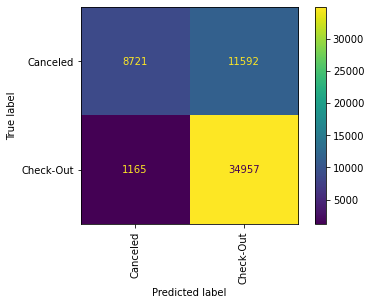

In [49]:
plot_confusion_matrix(model1, X_val_encoded, y_val, values_format='.0f', xticks_rotation='vertical');

In [50]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Canceled       0.87      0.43      0.58     20313
   Check-Out       0.75      0.96      0.84     36122

    accuracy                           0.77     56435
   macro avg       0.81      0.70      0.71     56435
weighted avg       0.79      0.77      0.75     56435



In [51]:
y_pred_probab1 = model1.predict_proba(X_val_encoded)
model1.classes_ 

array(['Canceled', 'Check-Out'], dtype=object)

In [52]:
roc_auc_score(y_val,y_pred_probab1[:,1])

0.8187973286446494

In [53]:
accuracy_score(y_val,y_pred1)

0.7725170550190484

In [54]:
probs = model1.predict_proba(X_val_encoded)
probs

array([[0.00507212, 0.9949279 ],
       [0.00105435, 0.99894565],
       [0.22400832, 0.7759917 ],
       ...,
       [0.0177719 , 0.9822281 ],
       [0.00393909, 0.9960609 ],
       [0.00393909, 0.9960609 ]], dtype=float32)

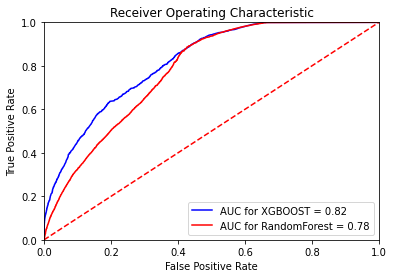

In [55]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs1 = model1.predict_proba(X_val_encoded)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_val, preds1, pos_label='Check-Out')
roc_auc1 = metrics.auc(fpr1, tpr1)

probs0 = model0.predict_proba(X_val)
preds0 = probs0[:,1]
fpr0, tpr0, threshold = metrics.roc_curve(y_val, preds0, pos_label ='Check-Out')
roc_auc0 = metrics.auc(fpr0, tpr0)


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc1)
plt.plot(fpr0, tpr0, 'r', label = 'AUC for RandomForest = %0.2f' % roc_auc0)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [56]:
model1.score(X_val_encoded,y_val)

0.7739523345441659

In [57]:
#.81 AUC before feature selection based on feature importances

In [58]:
!pip install matplotlib

In [59]:
!pip install pdpbox

In [60]:
#Looking at what the encodings signify
pd.options.display.max_rows = 50
print(encoder.mapping)

[{'col': 'meal', 'mapping': BB           1
FB           2
HB           3
SC           4
Undefined    5
NaN         -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'country', 'mapping': PRT     1
GBR     2
USA     3
ESP     4
IRL     5
       ..
GEO    95
TMP    96
MUS    97
ECU    98
NaN    -2
Length: 99, dtype: int64, 'data_type': dtype('O')}, {'col': 'distribution_channel', 'mapping': Direct       1
Corporate    2
TA/TO        3
Undefined    4
GDS          5
NaN         -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'reserved_room_type', 'mapping': C      1
A      2
D      3
E      4
G      5
F      6
H      7
L      8
B      9
NaN   -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'assigned_room_type', 'mapping': C       1
A       2
D       3
E       4
G       5
F       6
I       7
B       8
H       9
L      10
K      11
NaN    -2
dtype: int64, 'data_type': dtype('O')}, {'col': 'deposit_type', 'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype:

In [61]:
# labels for encoded columns:
##looking at encoder mappings
encoder.mapping[2]

{'col': 'distribution_channel',
 'mapping': Direct       1
 Corporate    2
 TA/TO        3
 Undefined    4
 GDS          5
 NaN         -2
 dtype: int64,
 'data_type': dtype('O')}

In [62]:
encoder.mapping[-1]

{'col': 'customer_type',
 'mapping': Transient          1
 Contract           2
 Transient-Party    3
 Group              4
 NaN               -2
 dtype: int64,
 'data_type': dtype('O')}

In [63]:

    from pdpbox.pdp import pdp_isolate, pdp_plot
    pdp_feature = 'country'
    isolated = pdp_isolate(
        model=model1,
        dataset=X_val_encoded,
        model_features=feature_names1,
        feature=pdp_feature,
    )

In [64]:
pdp_plot;

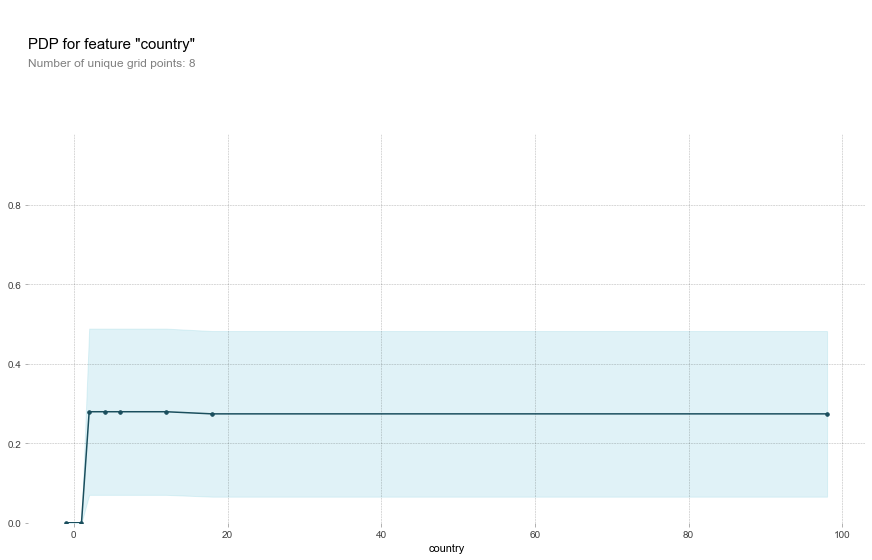

In [65]:
pdp_plot(isolated, feature_name= pdp_feature);

In [66]:
# seems like most countries are expected to have an equal likeley hood of checking in

In [67]:
pdp_feature2 = 'deposit_type'
isolated = pdp_isolate(
    model=model1,
    dataset=X_val_encoded,
    model_features=feature_names1,
    feature=pdp_feature2

)

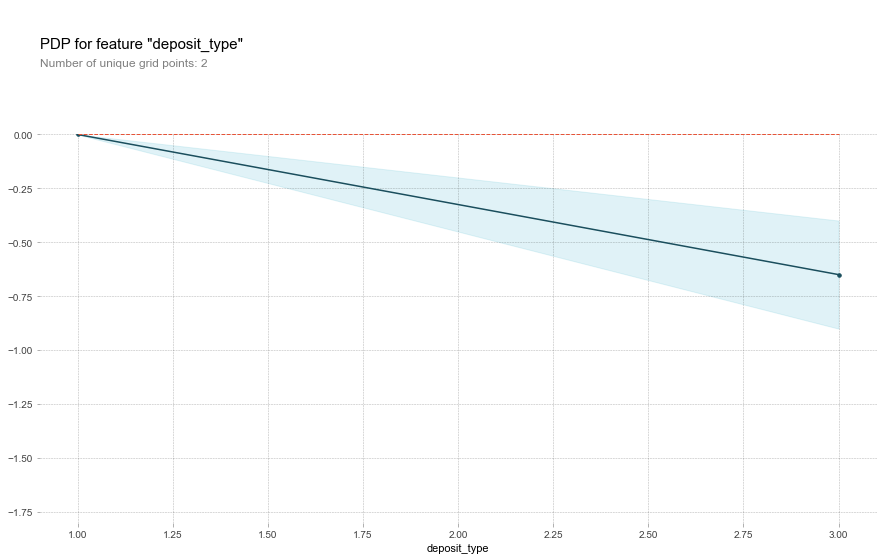

In [68]:
pdp_plot(isolated, feature_name= pdp_feature2);

In [69]:
#I interpret this model as: if the person made a nonrefundable deposit, there is a higher likeley hood he will check in
# The converse seems to be true as swell , If the person did't make a deposit, there is a higher likeley he will canceled

In [70]:
#previous_cancellations

In [71]:
!pip install shap
import shap

In [72]:
#individual observation to explain
row = X_val_encoded.iloc[[0]]
row

,lead_time,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal,country,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
reservation_status_date,,,,,,,,,,,,,,,,,,,
2016-01-02,109,1,2,0.0,0,0,0,0,0,59.94,0,1,1,20.0,3,2,3,1,3


In [73]:
#did the person check out or not for this observation?
y_val.iloc[[0]]

reservation_status_date
2016-01-02    Check-Out
Name: reservation_status, dtype: object

In [74]:
model1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [75]:
#what is the model's prediction?
model1.predict(row)

array(['Check-Out'], dtype=object)

In [76]:
model1.predict_proba(X_val_encoded)[0]

array([0.00507212, 0.9949279 ], dtype=float32)

In [77]:
model1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
#was having some problems w/ encoding 
#UnicodeDecodeError 
#this code solved the problem
#https://github.com/slundberg/shap/issues/1215


mybooster = model1.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

In [79]:
import shap
explainer = shap.TreeExplainer(model1)


In [80]:
shap_values = explainer.shap_values(row)
shap_values

array([[-0.9500219 ,  0.05651003, -0.08546285,  0.00899921,  0.00551929,
         0.58472484, -0.02327549, -0.10298645, -0.06340189,  0.14609005,
        -0.09428954,  0.34345514,  0.04497917,  2.8082087 , -0.0588048 ,
         0.4246354 ,  0.889093  ,  0.36408344,  0.18678284]],
      dtype=float32)

In [81]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
     link='logit'



)

In [82]:
pdp_two_features = ['deposit_type', 'country']

In [83]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
interaction = pdp_interact(
        model = model1,
        dataset = X_val_encoded,
        model_features=X_val_encoded.columns,
        features = pdp_two_features
)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x128b6eb70>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x128ce1eb8>})

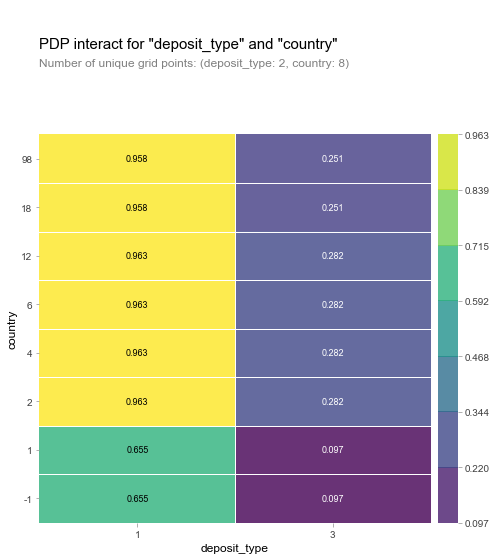

In [84]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=pdp_two_features)

In [85]:
random_forest = RandomForestClassifier(n_estimators=1)
random_forest.fit(X_train_encoded, y_train)

RandomForestClassifier(n_estimators=1)